In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt

# **MNIST Dataset**

In [ ]:
train = datasets.MNIST(
    root=".",
    train=True,
    download=True,
    transform=ToTensor()
)

train_data = [np.array(torch.flatten(data[:-1][0])) for data in train]
train_label = [data[-1] for data in train]

test = datasets.MNIST(
    root=".",
    train=False,
    download=True,
    transform=ToTensor()
)

test_data = [np.array(torch.flatten(data[:-1][0])) for data in test]
test_label = [data[-1] for data in test]

In [3]:
train_label_one_hot = np.zeros((len(train_label), 10))
train_label_one_hot[np.arange(len(train_label)), train_label] = 1
train_label_one_hot = torch.tensor(train_label_one_hot, dtype=float).float()

test_label_one_hot = np.zeros((len(test_label), 10))
test_label_one_hot[np.arange(len(test_label)), test_label] = 1
test_label_one_hot = torch.tensor(test_label_one_hot).float()

# **Bayes by Backprop (BBB)**
Gaussian Variational Posterior

In [5]:
def log_gaussian(x, mu, sigma):
    return float(-0.5 * np.log(2 * np.pi) - np.log(np.abs(sigma))) - (x - mu)**2 / (2 * sigma**2)

Gaussian: $\displaystyle f(x)=\frac 1 {\sigma \sqrt{2 \pi}} \exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)$ 

Log Gaussian: $\displaystyle \log f(x) = -\frac 1 2 \cdot \log(2\pi)-\log(|\sigma|)-\frac{(x-\mu)^2}{2\sigma^2}$


In [7]:
def log_gaussian_rho(x, mu, rho):
    return float(- 0.5 * np.log(2 * np.pi)) - torch.log(torch.log(1 + torch.exp(rho))) - (x - mu)**2 / (2 * torch.log(1 + torch.exp(rho))**2)

$\sigma = \log(1+\exp(\rho))$

Log Gaussian: $\displaystyle -\frac 1 2 \cdot \log(2\pi)-\log(\log(1+\exp(\rho)))-\frac{(x-\mu)^2}{2 \log(1+\exp(\rho))^2}$

In [8]:
class BNNLayer(nn.Module):
    def __init__(self, n_input, n_output, sigma_prior):
        super(BNNLayer, self).__init__()
        self.n_input = n_input
        self.n_output = n_output
        self.sigma_prior = sigma_prior
        self.W_mu = nn.Parameter(torch.Tensor(n_input, n_output).normal_(0, 0.01))
        self.W_rho = nn.Parameter(torch.Tensor(n_input, n_output).normal_(0, 0.01))
        self.b_mu = nn.Parameter(torch.Tensor(n_output).uniform_(-0.01, 0.01))
        self.b_rho = nn.Parameter(torch.Tensor(n_output).uniform_(-0.01, 0.01))
        self.lpw = 0
        self.lqw = 0
    
    def sample_epsilon(self):
        return Variable(torch.Tensor(self.n_input, self.n_output).normal_(0, self.sigma_prior)), Variable(torch.Tensor(self.n_output).normal_(0, self.sigma_prior))

    def forward(self, X, infer=False):
        if infer:
            output = torch.mm(X, self.W_mu) + self.b_mu.expand(X.size()[0], self.n_output)
            return output

        # Step 1
        epsilon_W, epsilon_b = self.sample_epsilon()

        # Step 2
        W = self.W_mu + torch.log(1 + torch.exp(self.W_rho)) * epsilon_W
        b = self.b_mu + torch.log(1 + torch.exp(self.b_rho)) * epsilon_b
        
        # Step 3
        self.lpw = log_gaussian(W, 0, self.sigma_prior).sum() + log_gaussian(b, 0, self.sigma_prior).sum()
        
        # Step 4
        self.lqw = log_gaussian_rho(W, self.W_mu, self.W_rho).sum() + log_gaussian_rho(b, self.b_mu, self.b_rho).sum()

        output = torch.mm(X, W) + b.expand(X.size()[0], self.n_output)
        return output

1. Sample unit Gaussian: $\epsilon \sim \mathcal{N}(0, I)$
2. Weights: $\textbf{w}=\mu+\log(1+\exp(\rho)) \circ \epsilon$ where $\sigma = \log(1+\exp(\rho))$
3. Prior: $\displaystyle w \sim \mathcal{N}(0, \sigma_0^2) \\
\log p(\textbf{w}) =-\frac 1 2 \cdot \log(2\pi)-\log(|\sigma_0|)-\frac{x^2}{2\sigma_0^2}$
4. Approximation: $\displaystyle w \sim \mathcal{N}(\mu, \sigma^2)\\
 \log q(w|\theta)= -\frac 1 2 \cdot \log(2\pi)-\rho-\frac{(x-\mu)^2}{2 e^{\rho \cdot 2}} $



(Paper Reference)

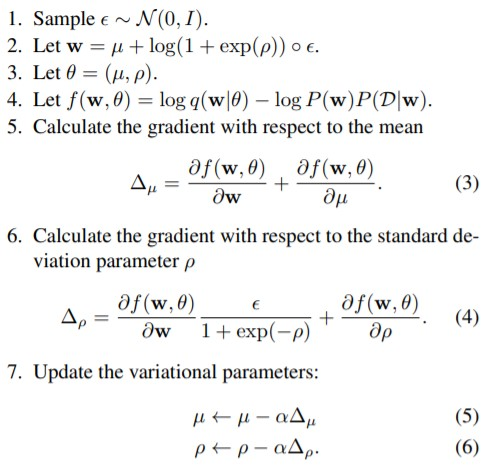

In [9]:
class BNN(nn.Module):
    def __init__(self, n_input, sigma_prior):
        super(BNN, self).__init__()
        self.l1 = BNNLayer(n_input, 200, sigma_prior)
        self.l1_relu = nn.ReLU()
        self.l2 = BNNLayer(200, 200, sigma_prior)
        self.l2_relu = nn.ReLU()
        self.l3 = BNNLayer(200, 200, sigma_prior)
        self.l3_relu = nn.ReLU()
        self.l4 = BNNLayer(200, 10, sigma_prior)
        self.l4_softmax = nn.Softmax()

    def forward(self, X, infer=False):
        output = self.l1_relu(self.l1(X, infer))
        output = self.l2_relu(self.l2(output, infer))
        output = self.l3_relu(self.l3(output, infer))
        output = self.l4_softmax(self.l4(output, infer))
        return output

    def get_lpw_lqw(self):
        lpw = self.l1.lpw + self.l2.lpw + self.l3.lpw + self.l4.lpw
        lqw = self.l1.lqw + self.l2.lqw + self.l3.lqw + self.l4.lqw
        return lpw, lqw

Sample $\mathbf{w}^{(i)}$ from $q(\mathbf{w}^{(i)}|\theta)$



In [10]:
def forward_pass_samples(X, y):
    s_log_pw, s_log_qw, s_log_likelihood = 0., 0., 0.
    for _ in range(n_samples):
        output = net(X)
        sample_log_pw, sample_log_qw = net.get_lpw_lqw()
        sample_log_likelihood = log_gaussian(y, output, sigma_prior).sum()
        s_log_pw += sample_log_pw
        s_log_qw += sample_log_qw
        s_log_likelihood += sample_log_likelihood

    return s_log_pw/n_samples, s_log_qw/n_samples, s_log_likelihood/n_samples

Loss function - variational free energy


$ f(\textbf{w}, \theta)=\frac{1}{M}(\log q(w|\theta)-\log p(w)) - p(\mathcal{D}|\textbf{w})$

M = number of batches

In [11]:
def loss_fn(l_pw, l_qw, l_likelihood):
    return ((1./n_batches) * (l_qw - l_pw) - l_likelihood).sum() / float(batch_size)

# **Training**

In [12]:
n_input = len(train_data[0])  

# Hyperparameters
sigma_prior = float(np.exp(-3))
n_samples = 3
learning_rate = 0.001
n_epochs = 150

In [13]:
# Initialize network
net = BNN(n_input, sigma_prior)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# Batch setting
batch_size = 1000
n_batches = len(train_data) / batch_size
n_train_batches = int(len(train_data) / batch_size)

log_pw, log_qw, log_likelihood = 0., 0., 0.
test_acc = []
test_err = []

# Training loop
for e in range(n_epochs):
    errs = []

    # Batch training
    for b in range(n_train_batches):
        net.zero_grad()

        # Obtain minibatch
        X = Variable(torch.Tensor(train_data[b * batch_size: (b+1) * batch_size]))
        y = Variable(torch.Tensor(train_label_one_hot[b * batch_size: (b+1) * batch_size]))

        log_pw, log_qw, log_likelihood = forward_pass_samples(X, y)
        loss = loss_fn(log_pw, log_qw, log_likelihood)

        errs.append(loss.data.numpy())
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        X_test = Variable(torch.Tensor(test_data))

        # Predict with softmax
        pred_test = net(X_test, infer=True)
        _, out_test = torch.max(pred_test, 1)

        out_test = out_test.data.numpy()
        test_label = np.array(test_label)

        # Evaluate
        acc_test = np.count_nonzero([out_test[i] == test_label[i] for i in range(out_test.shape[0])]) / out_test.shape[0]
        err_test = 1 - acc_test
        
    test_acc.append(acc_test)
    test_err.append(err_test)

    print ('epoch', e, 'loss', np.mean(errs), 'test acc', acc_test)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 0 loss 145.48921 test acc 0.209
epoch 1 loss 114.58074 test acc 0.5095
epoch 2 loss 41.297546 test acc 0.8917
epoch 3 loss -0.16117296 test acc 0.9345
epoch 4 loss -8.60138 test acc 0.9505
epoch 5 loss -12.808995 test acc 0.9574
epoch 6 loss -15.366996 test acc 0.9594
epoch 7 loss -17.206041 test acc 0.9643
epoch 8 loss -18.549707 test acc 0.9687
epoch 9 loss -19.68087 test acc 0.9707
epoch 10 loss -20.352201 test acc 0.973
epoch 11 loss -21.108938 test acc 0.9736
epoch 12 loss -21.83698 test acc 0.9744
epoch 13 loss -22.195004 test acc 0.9761
epoch 14 loss -22.677977 test acc 0.9776
epoch 15 loss -23.14776 test acc 0.9775
epoch 16 loss -23.600027 test acc 0.9781
epoch 17 loss -24.010494 test acc 0.9792
epoch 18 loss -24.284962 test acc 0.9802
epoch 19 loss -24.415936 test acc 0.981
epoch 20 loss -24.574446 test acc 0.9807
epoch 21 loss -24.787678 test acc 0.9808
epoch 22 loss -25.014227 test acc 0.9809
epoch 23 loss -25.04015 test acc 0.9815
epoch 24 loss -25.177622 test acc 0.9

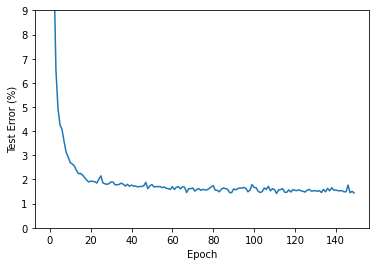

Test error is 1.44% after 150 epochs


In [14]:
test_err_plt = [err * 100 for err in test_err]

plt.plot(test_err_plt)
plt.xlabel('Epoch')
plt.ylabel('Test Error (%)')
plt.ylim(0, 9)
plt.show()

print(f'Test error is {test_err_plt[-1]:.2f}% after {n_epochs} epochs')

# plt.plot(test_acc, label="Test Accuracy")

Paper: https://arxiv.org/pdf/1505.05424.pdf

Code: https://gist.github.com/vvanirudh/9e30b2f908e801da1bd789f4ce3e7aac
